# Imports and Parameters

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
START_DATE = "2021-01-01"
END_DATE   = "2024-12-31"
TOP_N = 10
BENCHMARK = "^NSEI"

# Load Fundamentals Snapshot

In [8]:
fundamentals = pd.read_csv(
    "fundamentals_snapshot.csv",
    index_col="Ticker"
)

# Define Banks and Non-Banks

In [9]:
BANKS = [
    "HDFCBANK.NS","ICICIBANK.NS","SBIN.NS","AXISBANK.NS",
    "KOTAKBANK.NS","INDUSINDBK.NS","SBILIFE.NS",
    "BAJFINANCE.NS","BAJAJFINSV.NS","ICICIPRULI.NS","HDFCLIFE.NS"
]

NON_BANKS = [t for t in fundamentals.index if t not in BANKS]

bank_base = fundamentals.loc[BANKS].copy()
non_bank_base = fundamentals.loc[NON_BANKS].copy()

# Download Prices

In [10]:
tickers = list(fundamentals.index)

prices = yf.download(
    tickers + [BENCHMARK],
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True
)["Close"]

[*********************100%***********************]  48 of 48 completed


# Monthly Prices and Returns

In [11]:
monthly_prices = prices.resample("M").last()
monthly_returns = monthly_prices.pct_change().dropna()

benchmark_returns = monthly_returns[BENCHMARK]
monthly_returns = monthly_returns.drop(columns=BENCHMARK)

# Market Regime (Independent)

In [12]:
market_trend = benchmark_returns.rolling(12).sum()
regime_m = (market_trend > 0).astype(int)

# Helper Functions

In [19]:
def compute_momentum(prices, lookback):
    """
    Momentum Helper
    """
    return prices.shift(1) / prices.shift(lookback) - 1

def score_universe(df, universe, factors, weights):
    """
    Factor Scoring
    """
    ranks = pd.DataFrame(index=universe)
    for f in factors:
        ranks[f] = df[f].rank(ascending=False)
    composite = sum(ranks[f] * weights[f] for f in factors)
    return pd.DataFrame({"Composite": composite})

def quarterly_factor_returns(monthly_prices, monthly_returns, bank_base, non_bank_base, lookback, TOP_N):
    """
    Quarterly Rebalanced Factor Backtest
    """
    results = []
    rebalance_dates = monthly_returns.resample("Q").last().index

    for i, d in enumerate(rebalance_dates[:-1]):

        momentum = compute_momentum(
            monthly_prices.loc[:d], lookback
        ).iloc[-1]

        bank_snap = bank_base.copy()
        bank_snap["Momentum"] = momentum

        non_bank_snap = non_bank_base.copy()
        non_bank_snap["Momentum"] = momentum

        bank_scores = score_universe(
            bank_snap,
            bank_snap.index,
            ["Momentum","PB","ROE"],
            {"Momentum":0.2,"PB":0.1,"ROE":0.7}
        )

        non_bank_scores = score_universe(
            non_bank_snap,
            non_bank_snap.index,
            ["Momentum","PE","PB","ROE"],
            {"Momentum":0.2,"PE":0.1,"PB":0.1,"ROE":0.6}
        )

        scores = pd.concat([bank_scores, non_bank_scores])
        picks = scores.sort_values("Composite", ascending=False).head(TOP_N).index

        start, end = rebalance_dates[i], rebalance_dates[i+1]
        holding = monthly_returns.loc[start:end].iloc[1:]

        for date, row in holding.iterrows():
            results.append((date, row[picks].mean()))

    return pd.Series(
        [x[1] for x in results],
        index=[x[0] for x in results]
    )

def apply_regime_switch(factor_returns, benchmark_returns, regime):
    """
    Switches to factor returns when the regime goes to 0 (Sideways or Down)
    """
    df = pd.DataFrame({
        "Factor": factor_returns,
        "Benchmark": benchmark_returns.loc[factor_returns.index],
        "Regime": regime.loc[factor_returns.index]
    }).dropna()

    return pd.Series(
        np.where(df["Regime"] == 0, df["Factor"], df["Benchmark"]),
        index=df.index
    )

def performance_metrics(returns, rf=0.06):
    ann_ret = (1 + returns).prod() ** (12 / len(returns)) - 1
    vol = returns.std() * np.sqrt(12)
    sharpe = (ann_ret - rf) / vol
    dd = (1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1

    return pd.Series({
        "CAGR": ann_ret,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": dd.min()
    })

# Running Strategies

In [18]:
factor_6_1 = quarterly_factor_returns(
    monthly_prices, monthly_returns,
    bank_base, non_bank_base,
    lookback=6, TOP_N=TOP_N
)

factor_12_1 = quarterly_factor_returns(
    monthly_prices, monthly_returns,
    bank_base, non_bank_base,
    lookback=12, TOP_N=TOP_N
)

rs_6_1 = apply_regime_switch(factor_6_1, benchmark_returns, regime_m)

rs_12_1 = apply_regime_switch(factor_12_1, benchmark_returns, regime_m)

# Performance

In [20]:
bt_all = pd.DataFrame({
    "Always-On 6–1": factor_6_1,
    "Always-On 12–1": factor_12_1,
    "Regime-Switched 6–1": rs_6_1,
    "Regime-Switched 12–1": rs_12_1,
    "Benchmark": benchmark_returns.loc[rs_6_1.index]
}).dropna()

final_metrics = bt_all.apply(performance_metrics)
final_metrics

,Always-On 6–1,Always-On 12–1,Regime-Switched 6–1,Regime-Switched 12–1,Benchmark
CAGR,0.199800,0.160680,0.154773,0.137542,0.135321
Volatility,0.165685,0.163086,0.134008,0.137173,0.127177
Sharpe,0.843766,0.617341,0.707220,0.565286,0.592251
Max Drawdown,-0.163990,-0.171345,-0.110929,-0.165721,-0.107030


# Visualisation

### Cumulative Returns

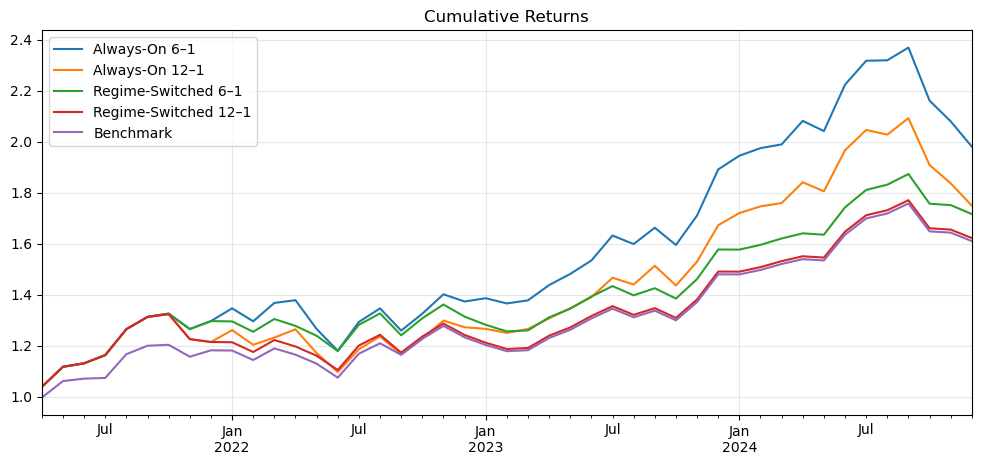

In [21]:
(1 + bt_all).cumprod().plot(figsize=(12,5))
plt.title("Cumulative Returns")
plt.grid(alpha=0.3)
plt.show()

### Drawdowns

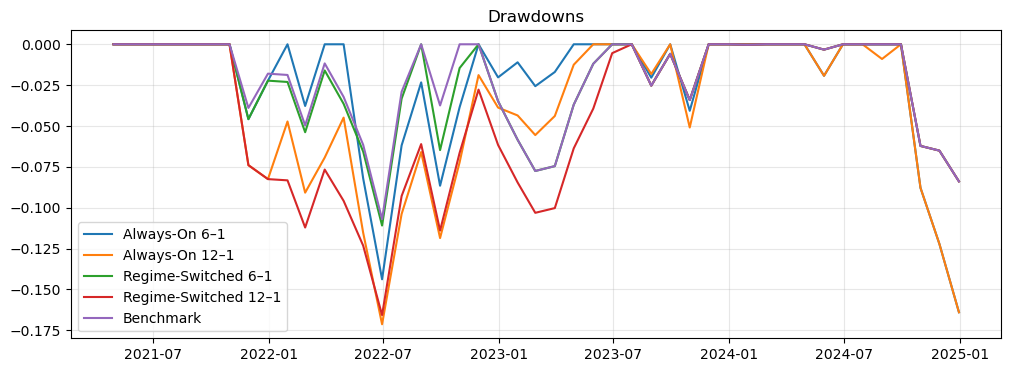

In [22]:
plt.figure(figsize=(12,4))
for col in bt_all.columns:
    dd = (1 + bt_all[col]).cumprod() / (1 + bt_all[col]).cumprod().cummax() - 1
    plt.plot(dd, label=col)

plt.title("Drawdowns")
plt.legend()
plt.grid(alpha=0.3)
plt.show()